#Metody numeryczne i optymalizacyjne
#Zadanie 5
##Filip Kobierski (242336), Artur Szewczykowski (252546)
## 26.05.2024 Wtorek 12:15

# 1. Polecenie




Celem zadania piątego było stworzenie programu implementującego metodę aproksymacji opartą o wielomiany Legendre'a:

- [X] Program daje do wyboru kilka funkcji: liniową, moduł, wielomianowa, trygonometryczną i ich złożenia.
- [X] Do obliczania wartości wielomianów użyto schematu Hornera.
- [X] Użytkownik wybiera aproksymowaną funkcję, przedział aproksymacji, stopień wielomianu aproksymującego oraz parametry związane z metodą całkowania takie jak ilość węzłów.
- [X] Program wyznacza wielomian aproksymacji podanego stopnia, rysuje jego wykres (wraz z wykresem funkcji oryginalnej) i oblicza błąd aproksymacji.
- [X] Dla chcących uzyskać 5 program posiada tryb pracy, w którym użytkownika określa oczekiwany błąd aproksymacji, a program iteracyjnie dobiera stopień wielomianu aproksymacyjnego zaczynając od stopnia 1.
- [X] Wartości współczynników wielomianów aproksymacyjnych są wyliczane w sposób iteracyjny i zapamiętywane w tablicy tak, aby możliwe było wykorzystanie tych współczynników w schemacie Hornera.

# 2. Teoria

##2.1 Teoria dotycząca całkowania numerycznego metodą Gaussa z wielomianami Legendre'a:

 Nie będzie tutaj powtórzona, ponieważ została już opisana w sprawozdaniu do zadania nr 4.

##2.2 Teoria dotycząca aproksymacji:

Metoda aproksymacji funkcji na węzłach Legendre'a polega na przybliżeniu danej funkcji za pomocą wielomianu interpolacyjnego, którego węzły (punkty, w których funkcja jest dokładnie określona) są zerami wielomianów Legendre'a.

Po zcałkowaniu funkcji nastepuje jej aproksymacja na podstawie wielomianu interpolacyjnego $P_n(x)$:
$$P_n(x) = \sum_{i=1}^{n} f(x_i)l_i(x)$$ gdzie $l_i(x)$ są wielomianami bazowymi Lagrande'a, definiowanymi jako:
$$l_i(x) = ∏_{j=0,j\ne i}^n \frac{x-x_j}{x_i - x_j}$$

# 3. Program

## 3.1 Importy i stałe (funkcje)
Stanardowo wykorzystaliśmy biblioteki `math` i `numpy`, oraz stworzoną przez nas wcześniej funkcję `hornerThis`:

In [2]:
import math; from math import sin, cos
import numpy as np
import matplotlib.pyplot as plt

INTERACTIVE = True

def hornerThis(x, coefs):
    rval = 0
    for i in coefs: rval = rval*x + coefs[i]
    return rval

do wyboru mamy następujące funkcje:
1. liniową: $x+1$
2. trygonometryczną: $\cos(x)$
3. wielomianową: $-x^2 + x -1$
4. moduł z *x* : $2*|x|$
5. złożoną: $(x+1)*sin(x)$
6. trygonometryczna: $sin(x)$

In [1]:
def fun(func_i, x):
    match func_i:
        case 1:return x + 1
        case 2:return cos(x)
        case 3:return hornerThis(x, (-3, 2, -1))
        case 4:return 2*abs(x)
        case 5:return (x+1)*sin(x)
        case 6:return sin(x)
        case _:raise ValueError(f"Unknown function index: {func_i}")


## 3.2 Całkowanie metodą Gaussa z wielomianami Legendre'a


In [74]:
def calculate_legendre_nodes_weights(n):
    nodes = np.zeros(n)
    weights = np.zeros(n)

    for i in range(1, n // 2 + 1):
        x = np.cos(np.pi * (4 * i - 1) / (4 * n + 2))
        q=0
        while q!=1:
            P_n = np.polynomial.legendre.Legendre.basis(n)(x)
            P_n_prime = n * (x * P_n - np.polynomial.legendre.Legendre.basis(n-1)(x)) / (x**2 - 1)
            x_new = x - P_n / P_n_prime
            if abs(x - x_new) < 1e-15:
                q=1
            else:
              x = x_new
        nodes[i - 1] = x
        nodes[n - i] = -x
        weights[i - 1] = 2 / ((1 - x**2) * (P_n_prime**2))
        weights[n - i] = weights[i - 1]

    return nodes, weights

In [38]:
def glThis(func_i, l_edg, r_edg, nodes_count):  # Gauss Legendre
    nodes, weights = calculate_legendre_nodes_weights(nodes_count)
    nodes_weights = list(zip(nodes, weights))
    integral = 0
    for xi, wi in nodes_weights:
        xi_mapped = (((r_edg - l_edg) * xi + (l_edg + r_edg)) / 2)

        # Sprawdź, czy func_i jest funkcją (lambda) czy indeksem
        if callable(func_i):
            result = func_i(xi_mapped)
        else:
            result = fun(func_i, xi_mapped)

        if result is None:
            raise ValueError(f"Function evaluation returned None for xi_mapped={xi_mapped}")
        integral += wi * result
    integral *= (r_edg - l_edg) / 2

    return integral, nodes_weights

## 3.3 Aproksymacja

In [25]:
def interpolate_legendre(func_i, nodes_weights):
    nodes = np.array([nw[0] for nw in nodes_weights])
    values = np.array([fun(func_i, xi) for xi in nodes])

# Oblicza k-ty wielomian bazowy Lagrange'a w punkcie x
    def L_k(x, k):
        L = 1
        for j in range(len(nodes)):
            if j != k:
                L *= (x - nodes[j]) / (nodes[k] - nodes[j])
        return L
# Oblicza wartość wielomianu interpolacyjnego w punkcie x
    def P_n(x):
        P = 0
        for k in range(len(nodes)):
            P += values[k] * L_k(x, k)
        return P

    return P_n, values

# Błąd aproksymacji
def calculate_error(P_n, func_i, l_edg, r_edg, nodes_weights):
    integral_exact, _ = glThis(func_i, l_edg, r_edg, len(nodes_weights))
    integral_approx, _ = glThis(lambda x: P_n(x), l_edg, r_edg, len(nodes_weights))
    error = abs(integral_exact - integral_approx)
    return error


## 3.4 Dodatkowy tryb z wprowadzonym oczekiwanym błędem aproksymacji

In [34]:
def find_approximation_with_error_tolerance(func_i, l_edg, r_edg, tolerance):
    degree = 1
    while True:
        nodes = degree + 1
        _, nodes_weights = glThis(func_i, l_edg, r_edg, nodes)
        P_n, coefs = interpolate_legendre(func_i, nodes_weights)

        test_points = np.linspace(l_edg, r_edg, 400)
        original_values = [fun(func_i, x) for x in test_points]
        interpolated_values = [P_n(x) for x in test_points]

        integral_exact, _ = glThis(func_i, l_edg, r_edg, len(nodes_weights))
        integral_approx, _ = glThis(lambda x: P_n(x), l_edg, r_edg, len(nodes_weights))
        error = abs(integral_exact - integral_approx)

        if error <= tolerance:
            plt.plot(test_points, original_values, label='Oryginalna funkcja')
            plt.plot(test_points, interpolated_values, label='Wielomian aproksymacyjny')
            plt.legend()
            plt.show()
            break

        degree += 1

    return degree, P_n, error

# 4. Badania

In [29]:
def last_function(func_i, l_edg, r_edg, degree):
    nodes = degree+1
    _, nodes_weights = glThis(func_i, l_edg, r_edg, nodes)
    P_n, coefs = interpolate_legendre(func_i, nodes_weights)
    test_points = np.linspace(l_edg, r_edg, 400)
    original_values = [fun(func_i, x) for x in test_points]
    interpolated_values = [P_n(x) for x in test_points]

    plt.plot(test_points, original_values, label='Oryginalna funkcja')
    plt.plot(test_points, interpolated_values, label='Wielomian aproksymacyjny')
    plt.legend()
    plt.show()

    error = calculate_error(P_n, func_i, l_edg, r_edg, nodes_weights)
    print(f"Wyniki aproksymacji funkcji {func_i} na przedziale od {l_edg} do {r_edg} \nwielomianem aproksymującym stopnia {degree} z błędem aproksymacji równym: {error}")


## 4.1 Funkcja liniowa: $x+1$

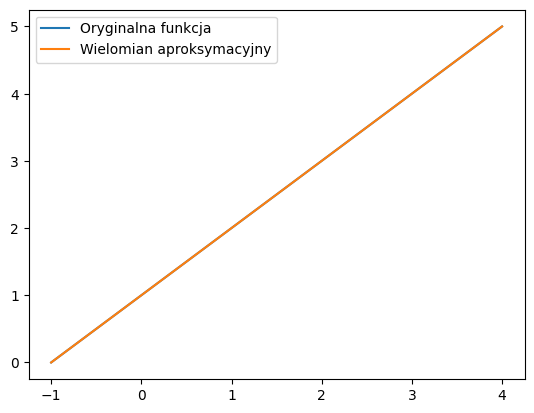

Wyniki aproksymacji funkcji 1 na przedziale od -1 do 4 
wielomianem aproksymującym stopnia 1 z błędem aproksymacji równym: 0.0


In [75]:
last_function(1, -1, 4, 1)

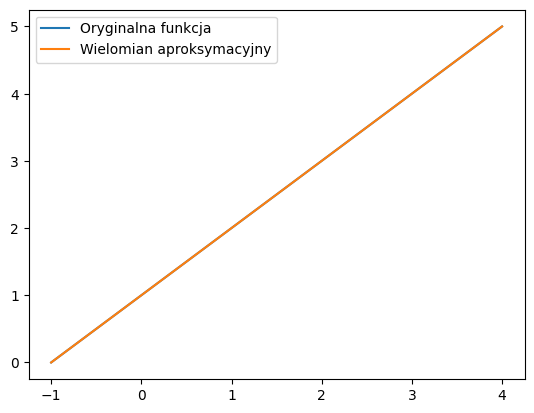

Wyniki aproksymacji funkcji 1 na przedziale od -1 do 4 
wielomianem aproksymującym stopnia 2 z błędem aproksymacji równym: 0.0


In [40]:
last_function(1, -1, 4, 2)

Dla funkcji liniowej stopień wielomianu aproksymującego, a co za tym idzie i liczba węzłów nie wpływa na dokładność aproksymacji - zaczynając od stopnia wielomianu aproksymującego równego 1 każde kolejne zwiększenie stopnia tego wielomianu nic nie zmienia w dokładności aproksymacji.

## 4.2 Funkcja trygonometryczna: $cos(x)$

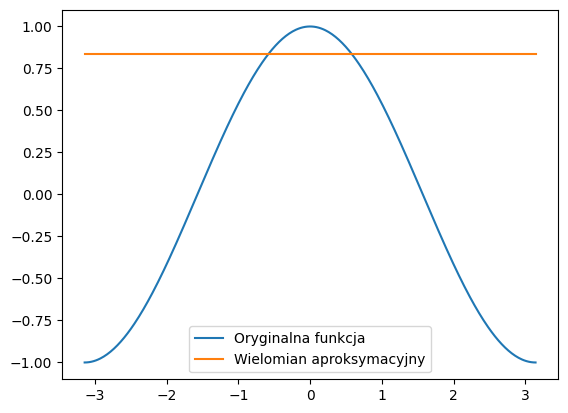

Wyniki aproksymacji funkcji 2 na przedziale od -3.141592653589793 do 3.141592653589793 
wielomianem aproksymującym stopnia 1 z błędem aproksymacji równym: 6.776605999548902


In [41]:
last_function(2,-1*math.pi,1*math.pi,1)

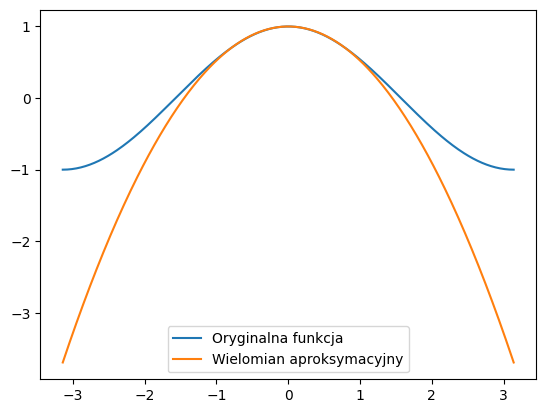

Wyniki aproksymacji funkcji 2 na przedziale od -3.141592653589793 do 3.141592653589793 
wielomianem aproksymującym stopnia 2 z błędem aproksymacji równym: 3.6867783011655817


In [42]:
last_function(2,-1*math.pi,1*math.pi,2)

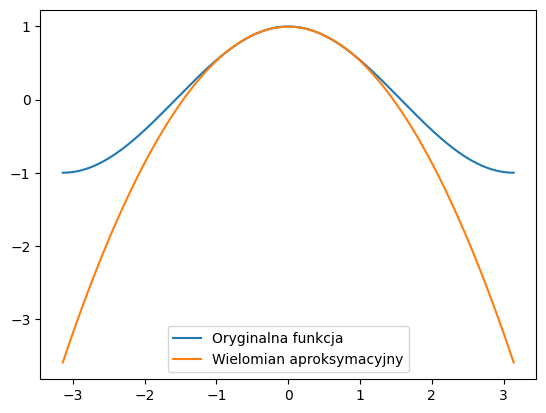

Wyniki aproksymacji funkcji 2 na przedziale od -3.141592653589793 do 3.141592653589793 
wielomianem aproksymującym stopnia 3 z błędem aproksymacji równym: 3.3474799685921797


In [43]:
last_function(2,-1*math.pi,1*math.pi,3)

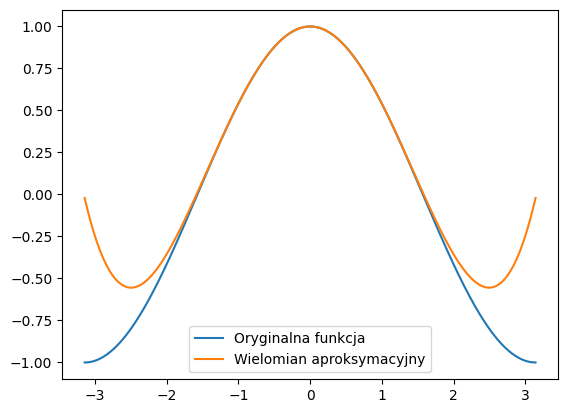

Wyniki aproksymacji funkcji 2 na przedziale od -3.141592653589793 do 3.141592653589793 
wielomianem aproksymującym stopnia 4 z błędem aproksymacji równym: 0.8686915131760946


In [44]:
last_function(2,-1*math.pi,1*math.pi,4)

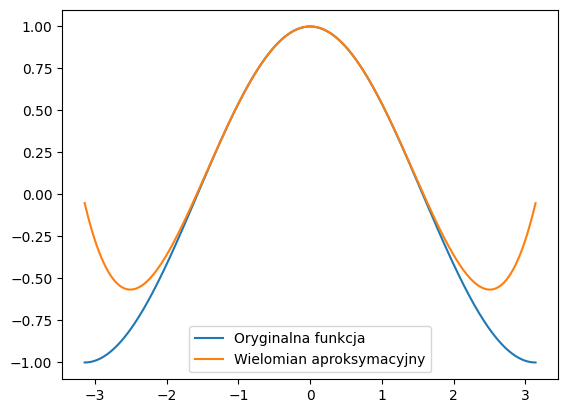

Wyniki aproksymacji funkcji 2 na przedziale od -3.141592653589793 do 3.141592653589793 
wielomianem aproksymującym stopnia 5 z błędem aproksymacji równym: 0.8330418752773248


In [45]:
last_function(2,-1*math.pi,1*math.pi,5)

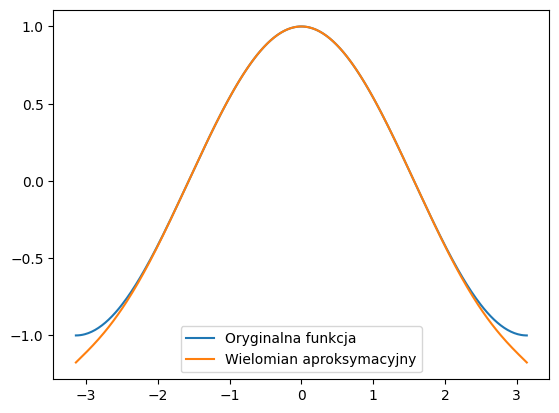

Wyniki aproksymacji funkcji 2 na przedziale od -3.141592653589793 do 3.141592653589793 
wielomianem aproksymującym stopnia 6 z błędem aproksymacji równym: 0.11846195098112755


In [46]:
last_function(2,-1*math.pi,1*math.pi,6)

Funkcja trygonometryczna cosinus jest aproksymowanym z zadowalającym błedem na poziomie 0,12 dopiero dla wielomianu aproksymującego stopnia 6 (7 węzłów)

## 4.3 Funkcja wielomianowa: $-x^2 + x -1$

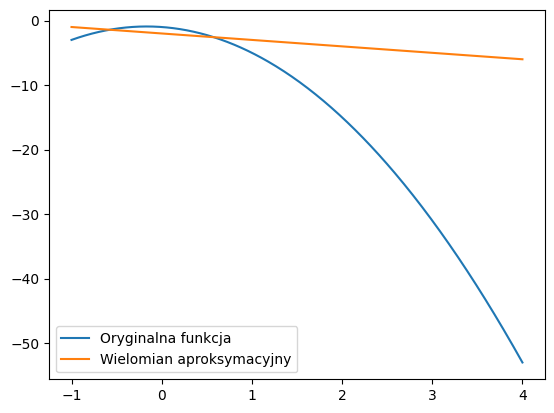

Wyniki aproksymacji funkcji 3 na przedziale od -1 do 4 
wielomianem aproksymującym stopnia 1 z błędem aproksymacji równym: 60.00000000000006


In [47]:
last_function(3,-1,4,1)

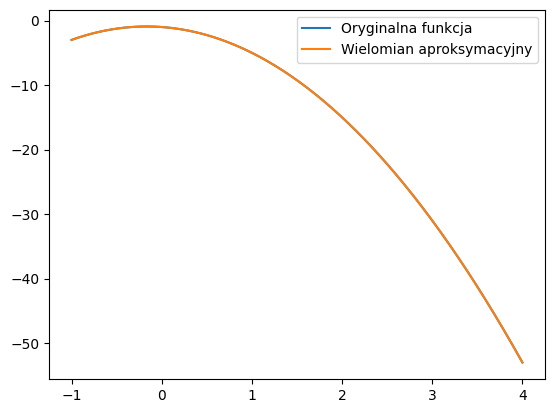

Wyniki aproksymacji funkcji 3 na przedziale od -1 do 4 
wielomianem aproksymującym stopnia 2 z błędem aproksymacji równym: 7.105427357601002e-15


In [48]:
last_function(3,-1,4,2)

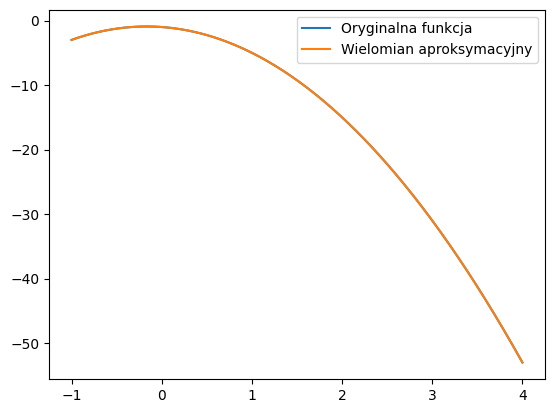

Wyniki aproksymacji funkcji 3 na przedziale od -1 do 4 
wielomianem aproksymującym stopnia 3 z błędem aproksymacji równym: 4.263256414560601e-14


In [49]:
last_function(3,-1,4,3)

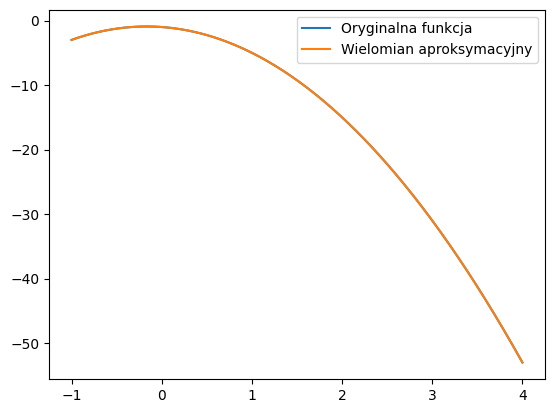

Wyniki aproksymacji funkcji 3 na przedziale od -1 do 4 
wielomianem aproksymującym stopnia 4 z błędem aproksymacji równym: 7.389644451905042e-13


In [50]:
last_function(3,-1,4,4)


Funkcję wielomianową należy aproksymować wielomianem identycznego stopnia jak stopień wielomianu - błąd aproksymacji wynosi wówczas zero.

Jeżeli aproksymujemy funkcję wielomianem większego stopnia niż ma on sam, to aproksymacja dalej pozostaje dokładna, ale nie jest równa idealnie 0.

Z kolei aproksymacja wielomianem niższego stopnia niż aproksymowana funkcja wielomianowa nie ma żadnego sensu.

## 4.4 Funkcja: $2*|x|$

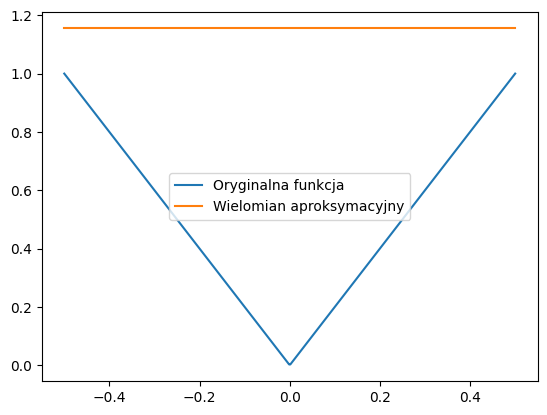

Wyniki aproksymacji funkcji 4 na przedziale od -0.5 do 0.5 
wielomianem aproksymującym stopnia 1 z błędem aproksymacji równym: 0.577350269189626


In [51]:
last_function(4,-0.5,0.5,1)

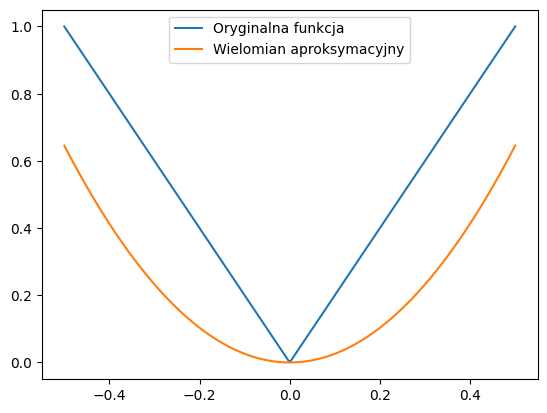

Wyniki aproksymacji funkcji 4 na przedziale od -0.5 do 0.5 
wielomianem aproksymującym stopnia 2 z błędem aproksymacji równym: 0.21516574145596754


In [52]:
last_function(4,-0.5,0.5,2)

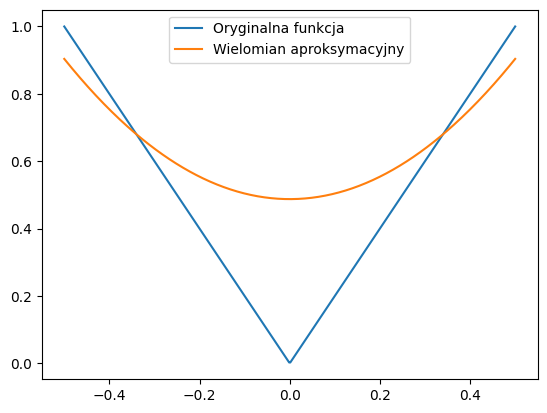

Wyniki aproksymacji funkcji 4 na przedziale od -0.5 do 0.5 
wielomianem aproksymującym stopnia 3 z błędem aproksymacji równym: 0.1049883715976363


In [53]:
last_function(4,-0.5,0.5,3)

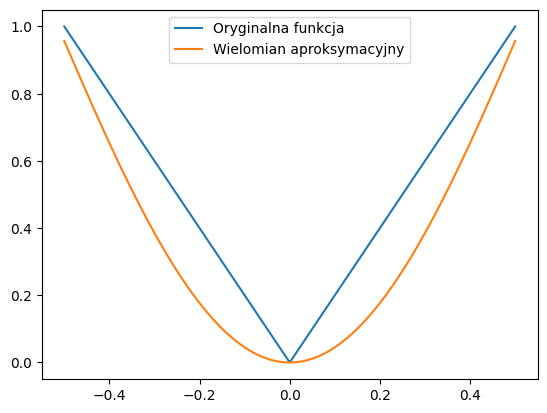

Wyniki aproksymacji funkcji 4 na przedziale od -0.5 do 0.5 
wielomianem aproksymującym stopnia 4 z błędem aproksymacji równym: 0.12981704527286936


In [54]:
last_function(4,-0.5,0.5,4)

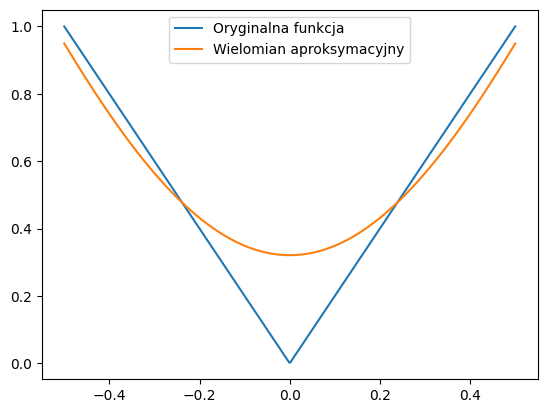

Wyniki aproksymacji funkcji 4 na przedziale od -0.5 do 0.5 
wielomianem aproksymującym stopnia 5 z błędem aproksymacji równym: 0.030463228219300253


In [55]:
last_function(4,-0.5,0.5,5)

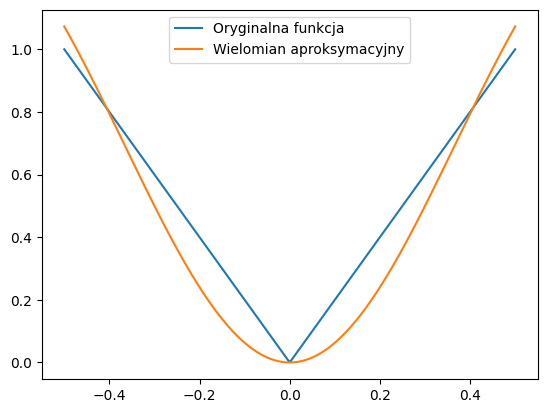

Wyniki aproksymacji funkcji 4 na przedziale od -0.5 do 0.5 
wielomianem aproksymującym stopnia 6 z błędem aproksymacji równym: 0.06277099397376035


In [56]:
last_function(4,-0.5,0.5,6)

Podobnie jak przy interpolacji - moduł z X jest funkcją parzystą, więc aproksymacja jest zadowalająca od wielomianu aproksymującego stopnia 2, z tym że wielomiany stopni nieparzystych mają mniejszy błąd aproksymacji, ale za to zakłamują wartość minimum aproksymowanej funkcji.

## 4.5 Funkcja złożona: $(x+1)*sin(x)$


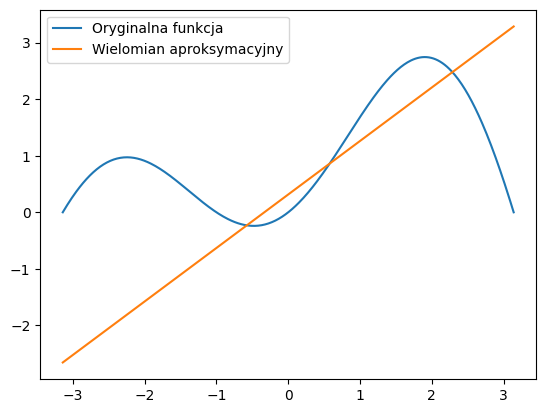

Wyniki aproksymacji funkcji 5 na przedziale od -3.141592653589793 do 3.141592653589793 
wielomianem aproksymującym stopnia 1 z błędem aproksymacji równym: 9.081643762657952


In [57]:
last_function(5, -1*math.pi, 1*math.pi,1)

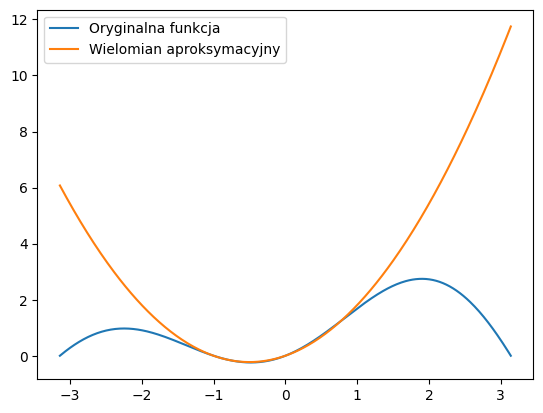

Wyniki aproksymacji funkcji 5 na przedziale od -3.141592653589793 do 3.141592653589793 
wielomianem aproksymującym stopnia 2 z błędem aproksymacji równym: 13.140046542274861


In [58]:
last_function(5, -1*math.pi, 1*math.pi,2)

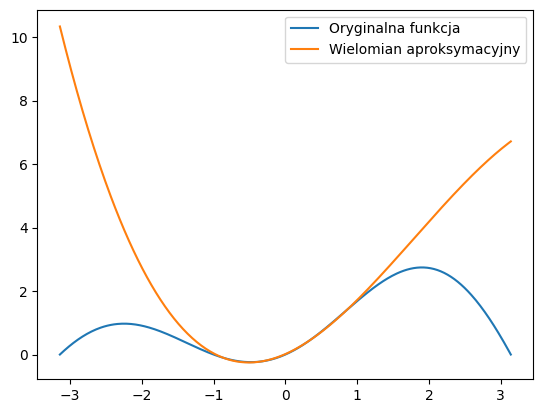

Wyniki aproksymacji funkcji 5 na przedziale od -3.141592653589793 do 3.141592653589793 
wielomianem aproksymującym stopnia 3 z błędem aproksymacji równym: 11.580168627330492


In [59]:
last_function(5, -1*math.pi, 1*math.pi,3)

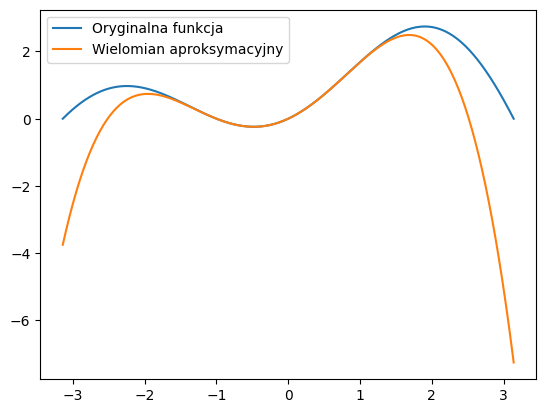

Wyniki aproksymacji funkcji 5 na przedziale od -3.141592653589793 do 3.141592653589793 
wielomianem aproksymującym stopnia 4 z błędem aproksymacji równym: 4.942246511103663


In [60]:
last_function(5, -1*math.pi, 1*math.pi,4)

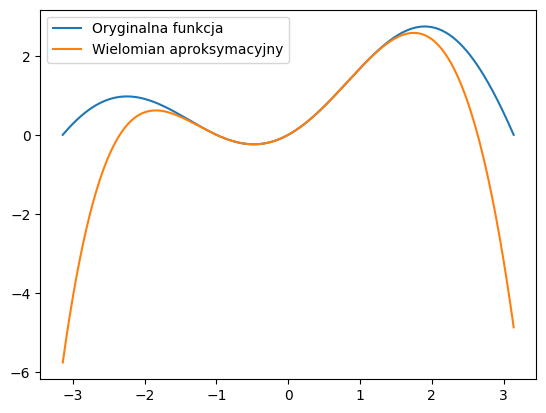

Wyniki aproksymacji funkcji 5 na przedziale od -3.141592653589793 do 3.141592653589793 
wielomianem aproksymującym stopnia 5 z błędem aproksymacji równym: 4.731156022973195


In [61]:
last_function(5, -1*math.pi, 1*math.pi,5)

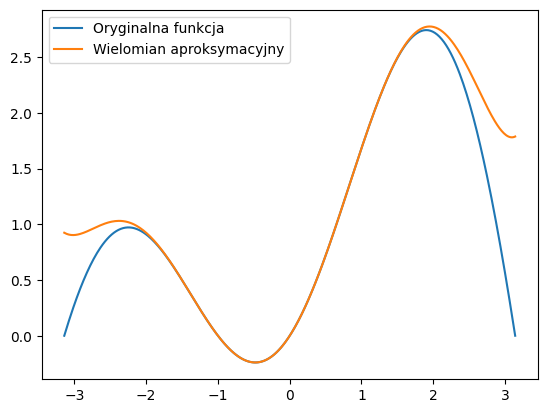

Wyniki aproksymacji funkcji 5 na przedziale od -3.141592653589793 do 3.141592653589793 
wielomianem aproksymującym stopnia 6 z błędem aproksymacji równym: 0.9225002163756963


In [62]:
last_function(5, -1*math.pi, 1*math.pi,6)

Dla tej funkcji złożonej wraz ze wzrostem stopnia wielomianu aproksymującej zmniejsza się bład aproksymacji. Prawdodpobonie gdyby kontynuować badania, to błąd aproksymacji osiągnąłby jeszcze mniejszą wartość.


## 4.6 Funkcja trygonometryczna: $sin(x)$

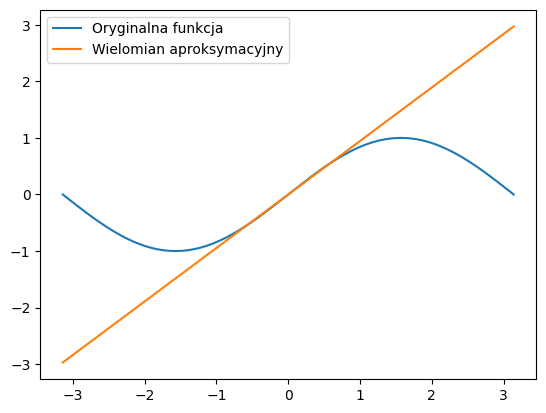

Wyniki aproksymacji funkcji 6 na przedziale od -3.141592653589793 do 3.141592653589793 
wielomianem aproksymującym stopnia 1 z błędem aproksymacji równym: 0.0


In [63]:
last_function(6, -1*math.pi, 1*math.pi, 1)

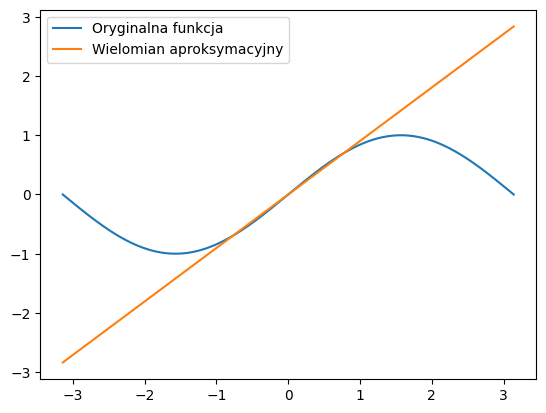

Wyniki aproksymacji funkcji 6 na przedziale od -3.141592653589793 do 3.141592653589793 
wielomianem aproksymującym stopnia 2 z błędem aproksymacji równym: 0.0


In [64]:
last_function(6, -1*math.pi, 1*math.pi, 2)

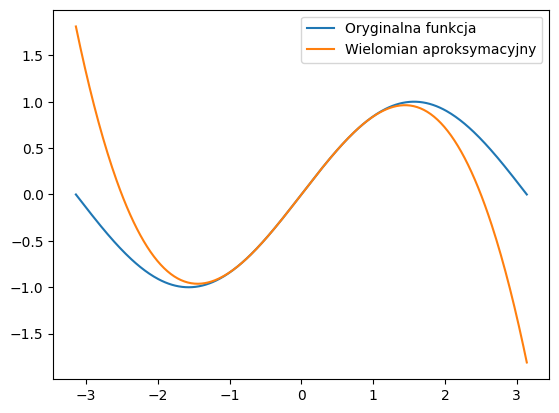

Wyniki aproksymacji funkcji 6 na przedziale od -3.141592653589793 do 3.141592653589793 
wielomianem aproksymującym stopnia 3 z błędem aproksymacji równym: 8.71967124502158e-17


In [65]:
last_function(6, -1*math.pi, 1*math.pi, 3)

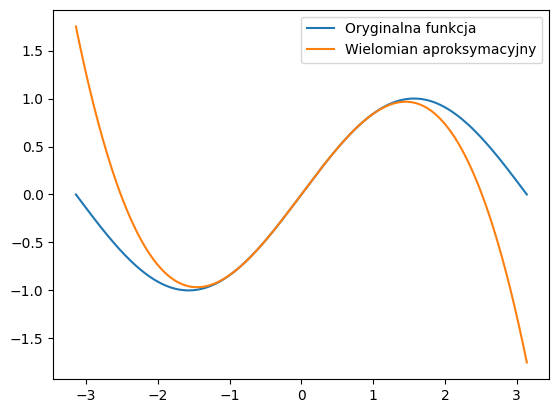

Wyniki aproksymacji funkcji 6 na przedziale od -3.141592653589793 do 3.141592653589793 
wielomianem aproksymującym stopnia 4 z błędem aproksymacji równym: 2.258394852460589e-14


In [66]:
last_function(6, -1*math.pi, 1*math.pi, 4)

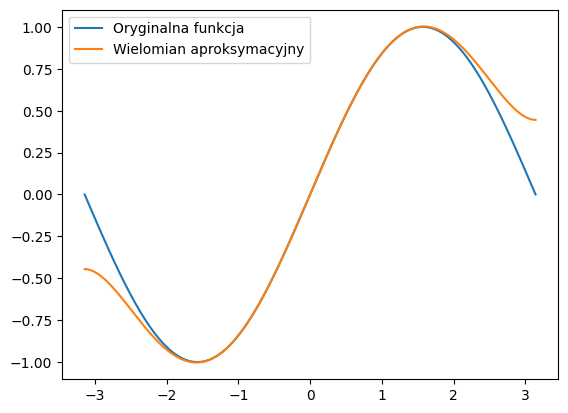

Wyniki aproksymacji funkcji 6 na przedziale od -3.141592653589793 do 3.141592653589793 
wielomianem aproksymującym stopnia 5 z błędem aproksymacji równym: 1.5477416459913303e-14


In [67]:
last_function(6, -1*math.pi, 1*math.pi, 5)

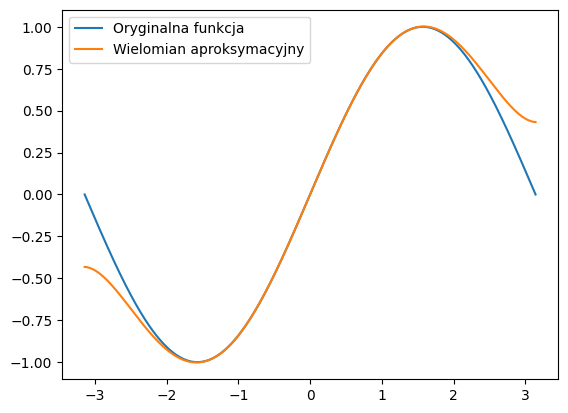

Wyniki aproksymacji funkcji 6 na przedziale od -3.141592653589793 do 3.141592653589793 
wielomianem aproksymującym stopnia 6 z błędem aproksymacji równym: 1.2597745031244928e-13


In [68]:
last_function(6, -1*math.pi, 1*math.pi, 6)

# 5. Część interaktywna z wyborem dodatkowego trybu

Użytkownik wybiera badaną funkcję, przedział aproksymacji, stopień wielomianu aproksymującego oraz parametry związane z wykorzystywaną metodą całkowania oraz dodatkowy tryb pracy umożliwiający użytkownika własnoręczne wybranie dokładności aproksymacji.

In [70]:
def printChoices():
  print("Dostępne funkcje:")
  print("1. x + 1")
  print("2. cos(x)")
  print("3. -x^2 + 2x - 3")
  print("4. 2*|x|")
  print("5. (x+1)*sin(x)")
  print("6. sin(x)")

def queryDetails():
  func_i = int(input("Wybierz numer funkcji: "))
  l_edg = float(input("Podaj początek przedziału: "))
  r_edg = float(input("Podaj koniec przedziału: "))
  tolerance_mode = input("Czy chcesz użyć trybu z oczekiwanym błędem aproksymacji? (y/n): ").lower() == 'y'
  return func_i, l_edg, r_edg, tolerance_mode


Dostępne funkcje:
1. x + 1
2. cos(x)
3. -x^2 + 2x - 3
4. 2*|x|
5. (x+1)*sin(x)
6. sin(x)
Wybierz numer funkcji: 3
Podaj początek przedziału: -1
Podaj koniec przedziału: 4
Czy chcesz użyć trybu z oczekiwanym błędem aproksymacji? (y/n): y
Podaj oczekiwany błąd aproksymacji: 1


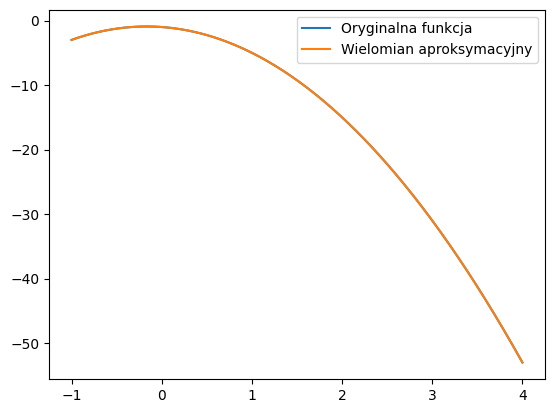

Znaleziono wielomian aproksymacyjny stopnia 2 z błędem aproksymacji równym 7.105427357601002e-15 <= 1.0


In [73]:
if INTERACTIVE:
  printChoices()
  func_i, l_edg, r_edg, tolerance_mode = queryDetails()
  if tolerance_mode:
    tolerance = float(input("Podaj oczekiwany błąd aproksymacji: "))
    degree, P_n, error = find_approximation_with_error_tolerance(func_i, l_edg, r_edg, tolerance)
    print(f"Znaleziono wielomian aproksymacyjny stopnia {degree} z błędem aproksymacji równym {error} <= {tolerance}")
  else:
    degree = int(input("Podaj stopień wielomianu aproksymacyjnego: "))
    last_function(func_i, l_edg, r_edg, degree)

# 6. Wnioski

Metoda interpolacji funkcji na węzłach Legendre'a jest uznawana za efektywną, ponieważ pozwala na uzyskiwanie dokładnych wyników przy stosunkowo małej liczbie węzłów.
Nasze badania potwierdzaję tę tezę, a dokładniej:
1. Dla funkcji liniowej:
- dla dokładnej aproksymacji wystarczy zastosować wielomian aproksymacyjny stopnia 1 (z 2 węzłami).
2. Dla funkcji trygonometrycznej:
- w przypadku funkcji cosinus zadowalająca aproksymacja (z wartością błędu rzędu 0,12) występuje przy aproksymacji wielomianem 6 stopnia (z 7 węzłami).
- w przypadku funkcji cosinus zadowalająca aproksymacja (z wartością błędu rzędu $10^-7$) występuje już przy aproksymacji wielomianem 3 stopnia (z 4 węzłami).
- w przypadku funkcji cosinus większą dokładność aproksymacji dają wielomiany stopni parzystych, w przypadku funkcji sinus nie widać specjalnej różnicy.
- w przypadku obu funkcji trygonometrycznych środkowa część wykresu na przedziale $[-π,π]$ jest bardzo szybko aproksymowana w prawidłowy sposób, ale trudności występują na krańcach wykresu.
3. Dla funkcji wielomianowej:
- należy ją aproksymować wielomianem identycznego stopnia jak stopień aproksymowanego wielomianu - błąd aproksymacji wynosi wówczas zero,

- jeżeli aproksymujemy funkcję wielomianem większego stopnia niż ma ona sama, to aproksymacja dalej pozostaje dokładna, ale jej błąd jest trochę większy niż 0 (im stopień aproksymującego wielomianu jest bardziej oddalony od stopnia aproksymowanej funkcji, tym ten błąd będzie coraz większy),

- z kolei aproksymacja wielomianem niższego stopnia niż aproksymowana funkcja wielomianowa nie ma
żadnego sensu, wynik takiej aproksymacji jest bardzo niedokładny.

4. Dla funkcji |x|:
- Podobnie jak przy interpolacji - moduł z X jest funkcją parzystą, więc aproksymacja jest zadowalająca od wielomianu aproksymującego stopnia 2, z tym że wielomiany stopni nieparzystych mają mniejszy błąd aproksymacji, ale za to zakłamują wartość minimum aproksymowanej funkcji.
5. Dla funkcji złożonej liniowowa*trygonometryczna:
- wraz ze wzrostem stopnia wielomianu aproksymującej zmniejsza się bład aproksymacji.
6. Najłatwiejsze do aproksymacji wielomianowej są funkcje wielomianowe - w bardzo łatwy sposób możemy określić jaki stopień wielomianu aproksymującego będzie najlepszy, co trudno powiedzieć o innych funkcjach (szczególnie gdybyśmy rozpatrywali jeszcze bardziej złożone funkcje np. sumę bądź iloczyn kilku funkcji trygonometrycznych).
7. Aproksymacja funkcji oparta o wielomiany Legendre'a pozwala aproksymować każdą funkcję ciągłą.
8. W celu wybrania najlepszego stopnia aproksymacji należy zastanowić się nad przebiegiem funkcji w danym przedziale. Ewentualnie można określić interesującą nas dokładność błędu aproksymacji i skorzystać z dodatkowego trybu programu, który sam znajduje najlepszy stopień.
